In [1]:
import numpy as np
from numpy.polynomial.hermite import Hermite
import matplotlib.pyplot as plt
import minnesota_hf_system as hfs
import harmonic_3d as h3d
from scipy.integrate import quad, dblquad
from scipy.special import genlaguerre, factorial2, binom
import time

wfs = []
for i in range(4):
    wfs.append(lambda r: h3d.wavefunction(r, k=i, l=0, omega=1, mass=1))

#hfs.System.two_dimensional_radial_integral(200, 1.487, wfs[0], wfs[1], wfs[2], wfs[3], integration_limit=10)

In [5]:
V0 = 200
mu = 1.487
integration_limit = 10

wfs = []
for i in range(4):
    wfs.append(lambda r: h3d.wavefunction(r, k=i, l=0, omega=1, mass=1))

potential_l0 = lambda x1, x2: - 0.5 * V0 / (2 * mu * x1 * x2) * np.exp(-mu * (x1 + x2)**2) * (-1 + np.exp(4 * mu * x1 * x2))

func = lambda x1, x2: x1**2 * x2**2 * wfs[0](x2) * wfs[1](x2) * potential_l0(x1, x2) * wfs[2](x2) * wfs[3](x2)

# There is some numerical prefactor I have to figure out here (is it 4pi?)

t0 = time.time()
radial_integral, error = dblquad(func, 0, integration_limit, 0, integration_limit)
radial_integral *= 4 * np.pi
t1 = time.time()
print(f"Time to compute integral: {t1 - t0}")

Time to compute integral: 16.492942094802856


In [2]:
from scipy import integrate, LowLevelCallable
from numba import cfunc
from numba.types import intc, CPointer, float64, int32

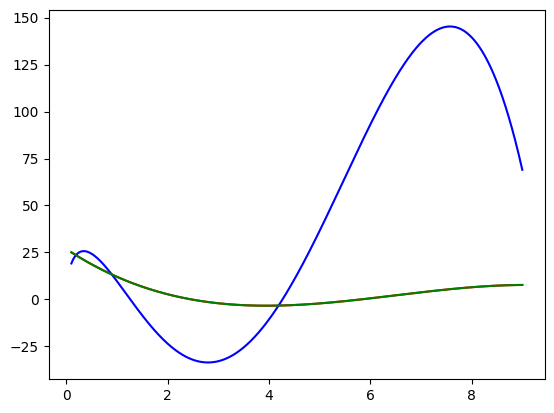

In [91]:
def gen_laguerre(x, n, alpha):
    if alpha == -0.5:
        return (-1)**n / (np.math.factorial(n) * 2**n) * Hermite.basis(2*n)(np.sqrt(x))
    elif alpha == 0.5:
        return (-1)**n / (np.math.factorial(n) * 2**(n+1)) * Hermite.basis(2*n+1)(np.sqrt(x))
    # else:
    #     return 1/x * ((x + alpha - 1) * gen_laguerre(x, n, alpha - 1) - (alpha - 1 + n) * gen_laguerre(x, n, alpha - 2))
    else:
        if n == 0:
            return gen_laguerre(x, n, alpha - 1)
        return gen_laguerre(x, n, alpha - 1) + gen_laguerre(x, n - 1, alpha)

def gen_laguerre_2(x, n, alpha):
    val = 0
    for i in range(n+1):
        val += (-1)**i * binom(n + alpha, n - i) * x**i / np.math.factorial(i)
    return val

x = np.linspace(0.1, 9, 1000)

n = 3
plt.plot(x, genlaguerre(n=n, alpha=3.5)(x), color="red")
plt.plot(x, gen_laguerre(x, n=n, alpha=3.5), color="blue")
plt.plot(x, gen_laguerre_2(x, n=n, alpha=3.5), color="green")

1.2404776949452792
0.9059168208047221


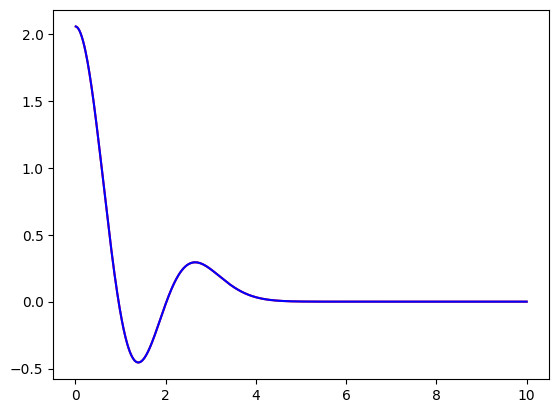

In [5]:
r = np.linspace(0.01, 10, 1000)
k = 2
l = 0

# Wavefunction expressed as a power series, avoids all sorts of weird functions and is accurate a.f.
def series_wavefunction(r, k, l, omega, mass):
    b = np.sqrt(1/(mass * omega))
    squiggle = r / b

    wf = np.zeros(r.shape)
    a_0 = 1
    a_prev = a_0

    for i in range(0, 30):
        if i == 0:
            a = a_0
        else:
            a = a_prev * ((i-1) - k) / (((i-1) + 1) * (l + (i-1) + 3/2))

        wf += a * squiggle ** (l + 2 * i)

        a_prev = a

    wf = wf * np.exp(-squiggle**2 / 2)
    
    # Normalize the wavefunction
    norm = np.sum(np.abs(wf)**2 * r**2) * (r[1] - r[0])
    wf /= np.sqrt(norm)
    
    return wf

def series_wavefunction_val(r, k, l, omega, mass, sqrt_norm):
    b = np.sqrt(1/(mass * omega))
    squiggle = r / b

    wf = 0
    a_0 = 1
    a_prev = a_0

    for i in range(0, 30):
        if i == 0:
            a = a_0
        else:
            a = a_prev * ((i-1) - k) / (((i-1) + 1) * (l + (i-1) + 3/2))

        wf += a * squiggle ** (l + 2 * i)

        a_prev = a
    
    wf = wf * np.exp(-squiggle**2 / 2)

    # Normalize the wavefunction
    wf /= sqrt_norm
    
    return wf

plt.plot(r, h3d.wavefunction(r, k=k, l=l, omega=1, mass=1), color="red")
plt.plot(r, series_wavefunction(r, k=k, l=l, omega=1, mass=1), color="blue")
#plt.plot(r, series_wavefunction_val(r, k=k, l=l, omega=1, mass=1, sqrt_norm=0.6656676819001949), color="green")

print(h3d.wavefunction(r=0.5, k=k, l=l, omega=1, mass=1))
print(series_wavefunction_val(r=0.5, k=k, l=l, omega=1, mass=1, sqrt_norm=0.6656676819001949))